In [1]:
import sys
sys.path.append('../src')
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sparse_coding_model import SparseCoding, normalize01
from utils import *
from train_funcs import load_models, generate_HVC
from sklearn.decomposition import DictionaryLearning
rng = np.random.default_rng()

In [2]:
fname = '../realistic_auditory_processing/learned_song_responses.npz'
T_SONG = np.load(fname)['ctrl'].shape[2] # (n_songs, N, T)

In [3]:
adult = dict(np.load('../adult_songs/data.npz'))
n_samples, n_syl, n_freq_bins, n_time_bins = adult['spec_syl'].shape
# xmin = adult['spec_syl'].min(axis=(0,2,3), keepdims=True) # syl-wise norm
# xmax = adult['spec_syl'].max(axis=(0,2,3), keepdims=True)
# adult['spec_syl'] = (adult['spec_syl'] - xmin) / (xmax - xmin)

In [4]:
# # Diction learning for each syllable
# n_basis_per_syl = 4
# basis = np.zeros((n_basis_per_syl*n_syl, n_freq_bins*n_time_bins))
# coefs = np.zeros((n_samples*n_syl, n_basis_per_syl*n_syl))
# for i in range(n_syl):
#     dl = DictionaryLearning(n_components=n_basis_per_syl, alpha=0.2,
#                             fit_algorithm='cd', positive_code=True)
#     a = dl.fit_transform(adult['spec_syl'][:,i].reshape(n_samples, -1))
#     a_std = a.std(keepdims=True)
#     p, q = i*n_basis_per_syl, (i+1)*n_basis_per_syl
#     coefs[i*n_samples:(i+1)*n_samples,p:q] = a / a_std
#     basis[p:q,:] = dl.components_ * a_std.T

In [5]:
n_basis = 20
basis = np.zeros((n_basis, n_freq_bins*n_time_bins))
coefs = np.zeros((n_samples*n_syl, n_basis))
dl = DictionaryLearning(n_components=n_basis, alpha=0.2, fit_algorithm='cd', 
                        positive_code=True, positive_dict=True)
aux = np.concatenate([adult['spec_syl'][:,i].reshape(n_samples, -1) 
                      for i in range(n_syl)])
coefs = dl.fit_transform(aux)
a_std = coefs.std(axis=0)[None,:]
coefs/= a_std
basis = dl.components_ * a_std.T

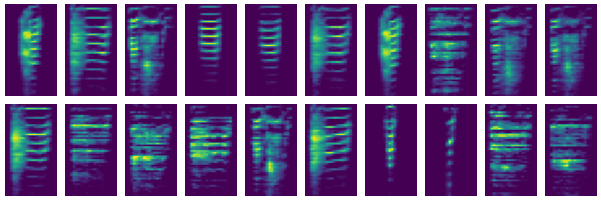

In [6]:
fig, ax = plt.subplots(2, 10, figsize=(6, 2))
ax = ax.flatten()
for i, b in enumerate(basis):
    if i >= len(ax):
        break
    ax[i].imshow(b.reshape(n_freq_bins, n_time_bins))
    ax[i].set_axis_off()

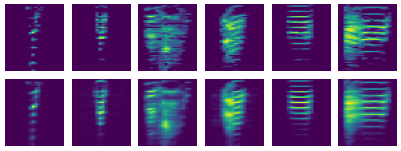

In [7]:
_ = coefs @ basis
fig, ax = plt.subplots(2, n_syl, figsize=(4, 1.5))
for i in range(n_syl):
    j = rng.integers(0,n_samples)
    ax[0,i].imshow(adult['spec_syl'][j,i])
    ax[1,i].imshow(_[i*n_samples+j].reshape(n_freq_bins, n_time_bins))
    ax[0,i].set_axis_off()
    ax[1,i].set_axis_off()

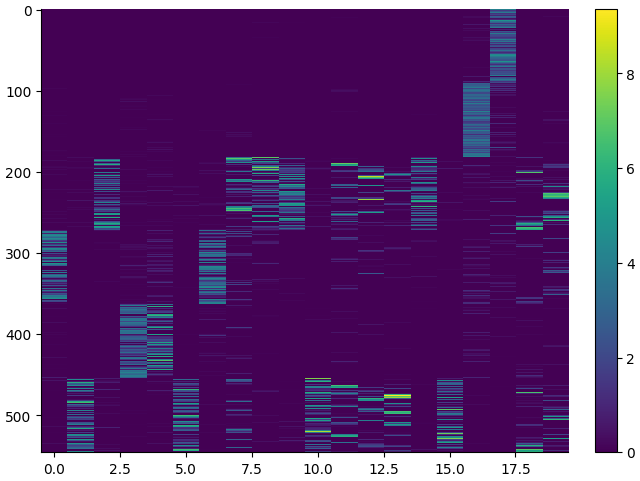

In [8]:
plt.imshow(coefs, interpolation='none')
plt.colorbar()
# fig, ax = plt.subplots(n_syl, figsize=(5, 6), sharex='all')
# for i in range(n_syl):
#     _ = coefs[i*n_samples:(i+1)*n_samples]
#     ax[i].errorbar(np.arange(n_basis_per_syl*n_syl), _.mean(axis=0), yerr=_.std(axis=0))

State at step $i$: $$s_i = \tau^{-1} \sum_{t'=0}^{\tau}\mathbf r^H(i\cdot\tau+t')$$

Action: 10-dimensionl coefficients for 10 basis of spectrograms $$a_i \sim N(\pi(s_i), \sigma I)$$

Reward: $$v_i = -m\left(\tau^{-1} \sum_{s=0}^{\tau} \mathbf r^E(\mathbf r^H(i\cdot\tau+s), a_i)\right)$$

In [9]:
class Environment:
    VOCAL_ERR_NET_MAP = {'FF': 0, 'EI-HVC2E': 1, 'EI-E2E': 2, 'EI-E2I2E': 3}
    STATE_INTERVAL = 60 # approximated length of the shortest syllable
    
    def __init__(self, action_basis, n_time_bins, T_song, 
                 dir_sensory_net, dir_vocal_error_net, vocal_error_net_type, 
                 T_burn=500, T_post=200, spec_dt=10,
                 HVC_peak_rate=150, HVC_kernel_width=20):
        # Constants
        self.T_song = T_song
        self.T_burn = T_burn
        self.T_post = T_post
        self.T = T_burn + T_song + T_post
        self.spec_dt = spec_dt
        
        # Store action basis
        # (n_basis, n_freq_bins*n_time_bins)
        self.action_basis = action_basis
        # self.action_basis = np.concatenate(action_basis, axis=0) 
        self.action_dim = self.action_basis.shape[0]
        
        # Load sensory net
        sensory_basis = torch.load(dir_sensory_net)
        assert sensory_basis.shape[0] % n_time_bins == 0
        self.n_sensory_basis = sensory_basis.shape[1]
        self.n_time_bins = n_time_bins
        self.n_freq_bins = sensory_basis.shape[0] // n_time_bins
        self.sensory = SparseCoding(n_basis=self.n_sensory_basis, 
                                    n_freq_bins=self.n_freq_bins, 
                                    n_time_bins=self.n_time_bins)
        self.sensory.basis = sensory_basis

        # Load vocal error net
        ret = load_models(dir_vocal_error_net, 'neighbor', 'EIIE', 'mature_hvc', 0)
        self.ve_net = ret[Environment.VOCAL_ERR_NET_MAP[vocal_error_net_type]]
        self.sensory_mapping = ret[-1]
        self.ve_net_in_dim, self.HVC_dim = self.ve_net.W.shape
        
        # Construct states from HVC firing
        burst_ts = np.linspace(T_burn, T_burn+T_song, num=self.HVC_dim, endpoint=False)
        aux = np.zeros((self.HVC_dim,1))
        self.rH = generate_HVC(T_burn+T_song+T_post, burst_ts[:,None], 
                               HVC_peak_rate+aux, HVC_kernel_width+aux)
        
        self.states = list(range(T_song//Environment.STATE_INTERVAL))
        self.state_dim = len(self.states)

        # Buffers
        self._cur_state = 0
        self._song_spec = np.zeros((self.n_freq_bins, (T_song+T_post)//self.spec_dt))
        self._song_emb = np.zeros((T_song+T_post, self.ve_net_in_dim))
    
    def _perform(self, action):
        if action is None: # silence
            bos = np.zeros((self.n_freq_bins, self.n_time_bins))
            emb = np.zeros(self.sensory_mapping.shape[-1])
        else:
            bos = (action.numpy() @ self.action_basis)
            bos = bos.reshape(self.n_freq_bins, self.n_time_bins)
            if np.allclose(bos, 0, atol=1e-4):
                emb = np.zeros(self.sensory_mapping.shape[-1])
            else:
                emb = self.sensory(torch.tensor(bos, dtype=torch.float32), n_iter_coef=200)
                emb = np.squeeze(emb.numpy()) @ self.sensory_mapping
            if np.isnan(emb).any():
                plt.imshow(bos)
        return bos, emb

    def reset(self):
        self._cur_state = 0
        self._song_spec[:] = 0
        self._song_emb[:] = 0
        return 0
    
    def step(self, action, song_spec=False):
        if self._cur_state >= len(self.states): # already done
            return None, True

        bos, emb = self._perform(action)

        # Determine how many intervals to jump
        dur = (bos.sum(axis=0) != 0).sum() * self.spec_dt # the duration of non-zero part
        step_size = int(np.round(dur / Environment.STATE_INTERVAL))
        step_size = 1 if step_size == 0 else step_size # if 0, treated as silence

        # Add to song embedding
        t0 = self._cur_state * Environment.STATE_INTERVAL
        t1 = (self._cur_state + step_size) * Environment.STATE_INTERVAL
        self._song_emb[t0:t1] = emb[None,:]
        
        if song_spec: # Add to song spectrum
            p, q = t0 // self.spec_dt, t1 // self.spec_dt # index range for song_spec
            mid = bos.shape[1] // 2 - 1 + bos.shape[1] % 2
            i, j = mid - step_size * 3, mid + step_size * 3 # clip range for bos
            if j > bos.shape[1]: # make it full spec width
                i, j = 0, self.n_time_bins
                q = p + self.n_time_bins        
            if q >= self._song_spec.shape[1]: # clip j
                j -= q - self._song_spec.shape[1]
            self._song_spec[:,p:q] = bos[:,i:j]
        
        self._cur_state += step_size # Update current state idx

        if self._cur_state >= len(self.states):
            return None, True
        else:
            return self._cur_state, False

    def init_ve_net(self):
        self.hE0 = rng.normal(loc=-10, scale=0.5, size=self.ve_net.NE)
        if hasattr(self.ve_net, 'NI'):
            self.hI0 = rng.normal(loc=-1, scale=0.5, size=self.ve_net.NI)
        else:
            self.hI0 = -1

    def reward(self, h0s=None):
        aud = np.zeros((self.T, self.ve_net_in_dim))
        aud[self.T_burn:self.T_burn+self._song_emb.shape[0]] = self._song_emb
        self.init_ve_net()
        hE0, hI0 = self.hE0, self.hI0
        rE, rI, _, hE, hI = self.ve_net.sim(hE0, hI0=hI0, rH=self.rH, aud=aud, 
                                            save_W_ts=[], T=self.T, dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        return -rE.mean(axis=1)

    def get_song_spec(self):
        return self._song_spec.copy()

In [10]:
from torch.distributions import Categorical, Bernoulli, Normal
import torch.nn.functional as F
class ActorCritic(nn.Module):
    def __init__(self, N_states, N_out):
        super(ActorCritic, self).__init__()
        m0 = -np.log(N_out/5 - 1)
        self.actor_mask = nn.Parameter(m0 * torch.ones(N_states, N_out, dtype=torch.float)) 
        self.actor_mean = nn.Parameter(2 * torch.ones(N_states, N_out, dtype=torch.float))
        self.actor_std = nn.Parameter(torch.ones(N_states, dtype=torch.float)/10)
        self.critic = nn.Parameter(-2 * torch.ones(N_states, dtype=torch.float))

    def forward(self, state):
        val = self.critic[state]
        
        prob_mask = F.sigmoid(self.actor_mask[state])
        
        mask_dist = Bernoulli(prob_mask)
        action_dist = Normal(self.actor_mean[state], F.softplus(self.actor_std[state]))
        
        mask = mask_dist.sample()
        action = action_dist.sample() * mask

        p_a_given_mask = torch.exp(action_dist.log_prob(action))
        #   P(a|b=1)P(b=1) + P(a|b=0)P(b=0) = P(a|b=1)P(b=1) + delta(a=0)(1-P(b=1))
        # = P(b=1) * (P(a|b=1) - 1 + b) + 1 - b
        prob = prob_mask * (p_a_given_mask - 1 + mask) + 1 - mask
        log_prob = torch.log(prob).sum()
        return action, val, log_prob
        
    def l1_penalty(self, coef):
        l = torch.linalg.norm(self.actor_mask + 5, 1)
        return l * coef

In [11]:
env = Environment(basis, n_time_bins, T_SONG,
                  '../realistic_auditory_processing/net_params.pkl', 
                  '../results/', 'EI-E2I2E')

In [12]:
agent = ActorCritic(env.state_dim, env.action_dim)

optimizer = torch.optim.Adam(agent.parameters(), lr=1e-2, weight_decay=0)

In [13]:
actor_losses, critic_losses, total_rewards, ve_rates = [], [], [], []
actions, songs = [], []
gamma = 0.9

for epoch in tqdm(range(1001)):
    rewards, log_probs, vals = [], [], []

    done = False
    state = env.reset() # 0
    states = [state]
    while not done:
        action, val, log_prob = agent(state)
        state, done = env.step(action, song_spec=epoch%10==0)
        
        log_probs.append(-log_prob)
        vals.append(val)
        if not done:
            states.append(state)
    
    rE = env.reward()
    
    if epoch % 10 == 0:
        songs.append(env.get_song_spec())
        ve_rates.append(rE.copy())

    # baseline subtraction; the rE here also includes the burning period from 0 to T_burn
    rE -= rE[200:].mean()
    itvl = Environment.STATE_INTERVAL # for convenience
    rewards = [rE[env.T_burn+states[t]*itvl:env.T_burn+states[t+1]*itvl].mean() 
               for t in range(len(states)-1)]
    rewards.append(rE[env.T_burn+states[-1]*itvl:].mean())
    rewards = np.array(rewards) * 10 + 2
    total_rewards.append(np.mean(rewards))

    Gs, G = [], 0
    for r in rewards[::-1]:
        G = r + G * gamma
        Gs.insert(0, G)
    # Gs = (np.array(Gs) - np.mean(Gs)) / np.std(Gs)
    actor_loss, critic_loss = 0, 0
    for G, lp, v in zip(Gs, log_probs, vals):
        advantage = G - v
        actor_loss += lp * advantage.item()
        # critic_loss += F.smooth_l1_loss(v, torch.tensor([G]))
        critic_loss += advantage**2

    critic_loss *= 10 # make it learn faster
    actor_loss += agent.l1_penalty(0.01)
    
    # if epoch % 50 == 0:
    #     print(actor_loss.item(), critic_loss.item())
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    
    optimizer.zero_grad()
    loss = actor_loss + critic_loss
    loss.backward()
    optimizer.step()
    # print('---')

 66%|██████████████████████████▌             | 664/1001 [06:10<03:08,  1.79it/s]


KeyboardInterrupt: 

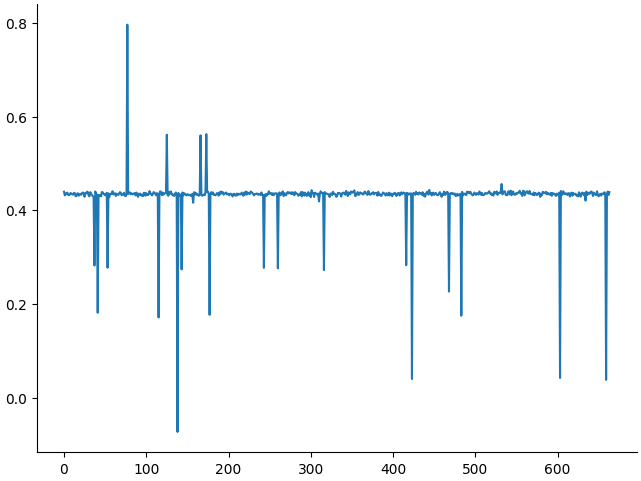

In [14]:
plt.plot(total_rewards)

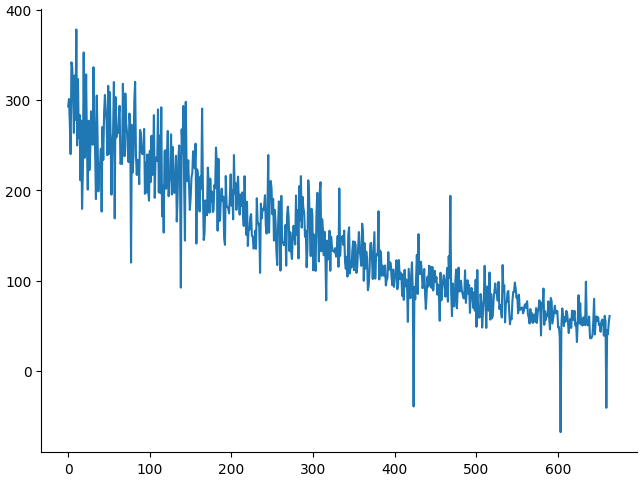

In [15]:
plt.plot(actor_losses)

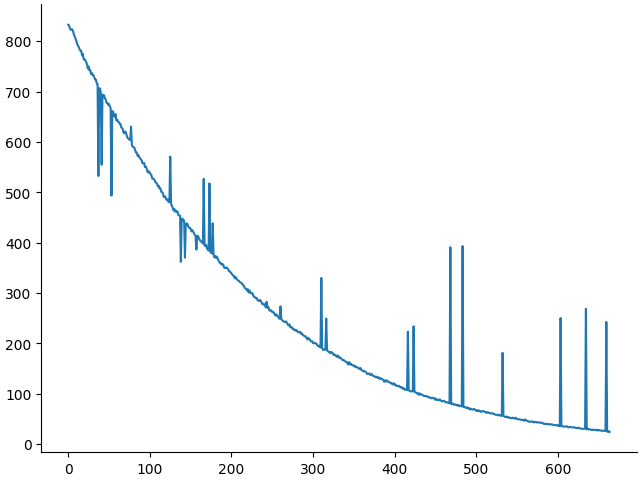

In [16]:
plt.plot(critic_losses)

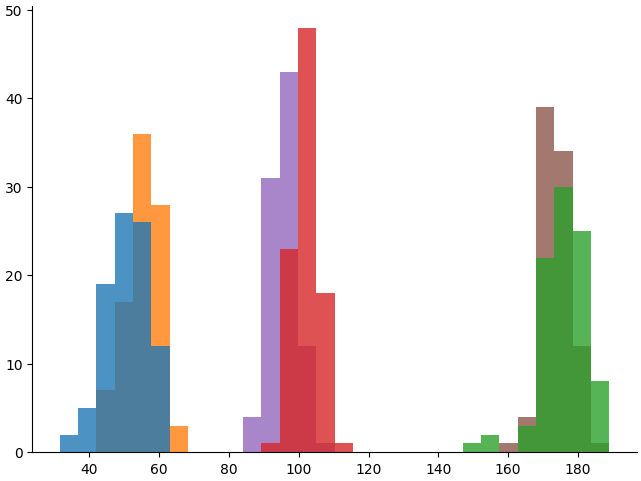

In [17]:
intervals = adult['syl_off'] - adult['syl_on']
plt.hist(intervals, histtype='stepfilled', alpha=0.8);

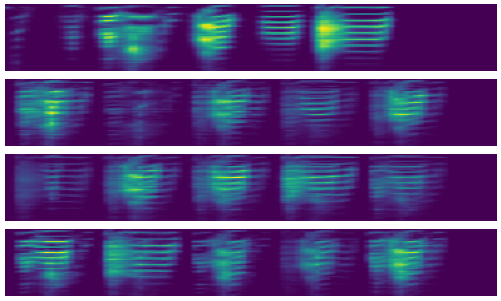

In [18]:
fig, ax = plt.subplots(4, figsize=(5, 3), sharex='all')
target = adult['spec_song'].mean(axis=0)
aux = np.zeros_like(songs[0])
aux[:,:target.shape[1]] = target
ax[0].imshow(aux)
ax[0].set_axis_off()
for i, j in enumerate((0, len(songs)//2, -1)):
    ax[i+1].imshow(songs[j], vmin=0)
    ax[i+1].set_axis_off()

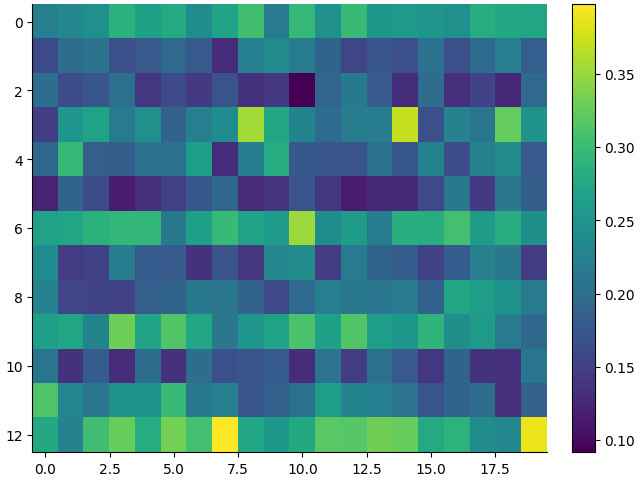

In [19]:
plt.imshow(F.sigmoid(agent.actor_mask.data))
plt.colorbar()